In [ ]:
pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
cars = pd.read_csv("Car dataset.csv")

In [ ]:
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [ ]:
def get_car_name_by_fuel(fuel):
    return list(cars[cars.fuel == fuel].name)[0]


def get_car_fuel_by_name(name):
    return list(cars[cars.name == name].fuel)[0]


def get_car_year_by_name(name):
    return list(cars[cars.name == name].year)[0]

def get_car_name_by_year(year):
    return list(cars[cars.year == year].name)[0]


def get_car_name_by_selling_price(selling_price):
    return list(cars[cars.selling_price == selling_price].name)


def get_car_selling_price_by_name(name):
    return list(cars[cars.name == name].selling_price)

# Construct the cars graph

###### We create an edge between two car nodes in the graph if both cars have the same fuel.

In [ ]:

pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)


# Group cars by fuel.
cars_grouped_by_fuel = list(cars.groupby("fuel"))

for group in tqdm(
    cars_grouped_by_fuel,
    position=0,
    leave=True,
    desc="Compute cars frequencies",
):
    # Get a list of cars with the same fuel.
    current_cars = list(group[1]["name"])

    for i in range(len(current_cars)):
        item_frequency[current_cars[i]] = 1              
        for j in range(i + 1, len(current_cars)):
            x = min(current_cars[i], current_cars[j])   
            y = max(current_cars[i], current_cars[j])
            pair_frequency[(x, y)] = 1     

Compute cars frequencies: 100%|██████████| 4/4 [00:15<00:00,  3.84s/it]


In [ ]:
# Create the cars undirected graph.
cars_graph = nx.Graph()

for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the cars graph"
):
    x, y = pair
    cars_graph.add_edge(x, y,weight = 1)

Creating the cars graph: 100%|██████████| 1033096/1033096 [00:02<00:00, 452750.96it/s]


###### Let's display the total number of nodes and edges in the graph

In [ ]:
print("Total number of graph nodes:", cars_graph.number_of_nodes())
print("Total number of graph edges:", cars_graph.number_of_edges())

Total number of graph nodes: 2058
Total number of graph edges: 1033096


Let's display the average node degree (number of neighbours) in the graph.

In [ ]:
degrees = []
for node in cars_graph.nodes:
    degrees.append(cars_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 1003.98


### Step 3: Create vocabulary and a mapping from tokens to integer indices

In [ ]:
vocabulary = ["NA"] + list(cars_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [ ]:
print(vocabulary_lookup)

{'NA': 0, 'Maruti Alto 800 CNG LXI Optional': 1, 'Maruti Wagon R LXI CNG': 2, 'Maruti Eeco CNG 5 Seater AC': 3, 'Maruti Alto 800 CNG LXI': 4, 'Maruti Eeco CNG 5 Seater AC BSIV': 5, 'Hyundai Santro Xing GL CNG': 6, 'Hyundai Santro Xing GL PLUS CNG': 7, 'Maruti Wagon R CNG LXI': 8, 'Hyundai Santro Xing GLS CNG': 9, 'Maruti Zen Estilo LXI Green (CNG)': 10, 'Tata Indica V2 Emax CNG GLX': 11, 'Maruti Omni CNG': 12, 'Maruti Eeco CNG HTR 5-STR': 13, 'Hyundai Accent Executive CNG': 14, 'Maruti SX4 Green Vxi (CNG)': 15, 'Maruti Ertiga VXI CNG Limited Edition': 16, 'Maruti Alto K10 LXI CNG': 17, 'Hyundai Accent GLE CNG': 18, 'Maruti Alto 800 LXI CNG': 19, 'Maruti Wagon R LXI CNG Optional': 20, 'Hyundai Santro AT CNG': 21, 'Maruti Alto Green LXi (CNG)': 22, 'Maruti Eeco 5 STR With AC Plus HTR CNG': 23, 'Maruti Swift Dzire VDI': 24, 'Skoda Rapid 1.5 TDI Ambition': 25, 'Hyundai i20 Sportz Diesel': 26, 'Toyota Etios VXD': 27, 'Ford Figo Diesel Celebration Edition': 28, 'Renault Duster 110PS Diesel R

# Implement the biased random walk

In [ ]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))   

    weights = []        
    
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

# Generate training data using the biased random walk

In [ ]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(cars_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))


Random walks iteration 5 of 5: 100%|██████████| 2058/2058 [00:44<00:00, 45.88it/s]

Number of walks generated: 10290


In [ ]:
print("Number of nodes in walk number 1:", len(walks[0]))
print("Number of nodes in walk number 7025:", len(walks[7024]))

Number of nodes in walk number 1: 10
Number of nodes in walk number 7025: 10


In [ ]:
for i in range(10):
  print(walks[i])

[1993, 1264, 1955, 1919, 1714, 1729, 1696, 1953, 1619, 1524]
[379, 618, 965, 1016, 854, 485, 223, 205, 868, 630]
[1054, 598, 768, 90, 679, 856, 352, 858, 1029, 942]
[303, 826, 931, 718, 790, 260, 964, 224, 206, 589]
[208, 791, 981, 884, 406, 230, 826, 302, 1021, 134]
[862, 568, 771, 428, 859, 1113, 542, 258, 254, 340]
[90, 678, 527, 1062, 1112, 163, 899, 658, 1122, 618]
[265, 1004, 201, 883, 995, 600, 995, 953, 174, 523]
[42, 358, 342, 507, 32, 34, 825, 76, 415, 498]
[1931, 1801, 1390, 1473, 1185, 1393, 1349, 1335, 1209, 1534]


# Generate positive and negative examples

In [ ]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 10290/10290 [00:19<00:00, 515.12it/s]


##### Let's display the shapes of the outputs

In [ ]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (2107960,)
Contexts shape: (2107960,)
Labels shape: (2107960,)
Weights shape: (2107960,)


### Convert the data into tf.data.Dataset objects

In [ ]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)


# Train the skip-gram model

In [ ]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

### Implement the model

In [ ]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Train the model

In [ ]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

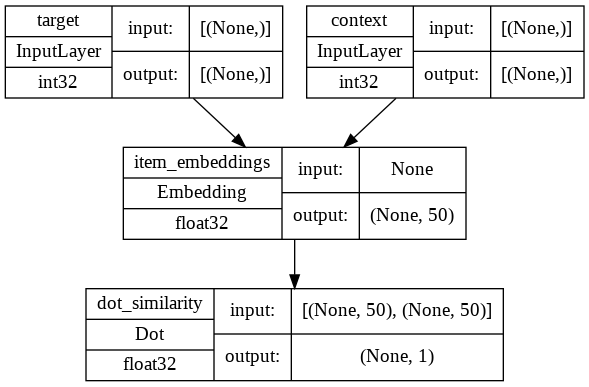

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [ ]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
2058/2058 [==============================] - 17s 8ms/step - loss: 1.4953
Epoch 2/10
2058/2058 [==============================] - 15s 8ms/step - loss: 1.4785
Epoch 3/10
2058/2058 [==============================] - 15s 7ms/step - loss: 1.4753
Epoch 4/10
2058/2058 [==============================] - 15s 7ms/step - loss: 1.4729
Epoch 5/10
2058/2058 [==============================] - 16s 8ms/step - loss: 1.4706
Epoch 6/10
2058/2058 [==============================] - 16s 8ms/step - loss: 1.4678
Epoch 7/10
2058/2058 [==============================] - 15s 8ms/step - loss: 1.4648
Epoch 8/10
2058/2058 [==============================] - 15s 7ms/step - loss: 1.4619
Epoch 9/10
2058/2058 [==============================] - 14s 7ms/step - loss: 1.4592
Epoch 10/10
2058/2058 [==============================] - 17s 8ms/step - loss: 1.4568


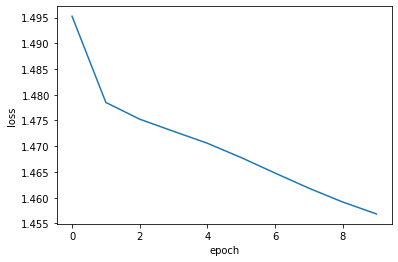

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Analyze the learnt embeddings

In [ ]:
car_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", car_embeddings.shape)

Embeddings shape: (2059, 50)


### Find similair cars

In [ ]:
query_cars = [
    "Audi A6 2.0 TDI  Design Edition"
]

In [ ]:
query_embeddings = []

for name in query_cars:
    token_id = vocabulary_lookup[name]
    car_embedding = car_embeddings[token_id]
    query_embeddings.append(car_embedding)

query_embeddings = np.array(query_embeddings)

In [ ]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(car_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [ ]:
for idx, title in enumerate(query_cars):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_car_name = vocabulary[token]
        print(f"- {similar_car_name}")
    print()

Audi A6 2.0 TDI  Design Edition
-------------------------------
- Audi A6 2.0 TDI  Design Edition
- Tata Sumo EX
- Mahindra Renault Logan 1.5 Diesel DLSX
- Skoda Octavia Rider 1.9 AT TDI
- Volvo S90 D4 Inscription BSIV

